# Import Package

In [1]:
# Evaluation Metric Packages
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# Dataset loading Packages
from zipfile import ZipFile
from PIL import Image
from io import BytesIO

# Utilities
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Neural Network Learning Packages
import tensorflow as tf
from tensorflow.keras import backend as K

print("Num GPUs Available: ",
      len(tf.config.experimental.list_physical_devices('GPU')))
tf.random.set_seed(0)

Num GPUs Available:  2


In [2]:
r_seed = 0
np.random.seed(r_seed)

omniglot_data_path = 'data/1_raw/omniglot/images_evaluation.zip'
sample_size = 10000

# Preparing Data

## MNIST and MNIST-Noise and Noise

In [3]:
mnist = tf.keras.datasets.mnist

(x_mnist_train, y_mnist_train), (x_mnist_test,
                                 y_mnist_test) = mnist.load_data()
x_mnist_train, x_mnist_test = x_mnist_train / 255.0, x_mnist_test / 255.0

# introduce noise to mnist
x_mnist_noise_test = x_mnist_test.copy()
random_noise = np.random.uniform(
    0, 1, x_mnist_noise_test[np.where(x_mnist_noise_test == 0)].shape[0])
x_mnist_noise_test[np.where(x_mnist_noise_test == 0)] = random_noise

x_noise_test = np.random.uniform(0, 1, (sample_size, 28, 28))

In [4]:
for i in range(6):
    im = Image.fromarray(np.uint8(x_mnist_test[i]*255))
    display(im)
    im.save('mnist_{}.pdf'.format(i))
    
for i in range(6):
    im = Image.fromarray(np.uint8(x_mnist_noise_test[i]*255))
    display(im)
    im.save('mniNo_{}.pdf'.format(i))
    
for i in range(6):
    im = Image.fromarray(np.uint8(x_noise_test[i]*255))
    display(im)
    im.save('noise_{}.pdf'.format(i))

## Omniglot

In [5]:
def load_omniglot_eval(data_path):
    omniglot_data_list = []
    with ZipFile(data_path) as zf:
        for filename in zf.namelist():
            if '.png' in filename:
                zip_data = zf.read(filename)
                bytes_io = BytesIO(zip_data)
                pil_img = Image.open(bytes_io)
                pil_img = pil_img.resize((28, 28))
                omniglot_data_list.append([1 - np.array(pil_img) * 1.0])

    omniglot_data = np.concatenate(omniglot_data_list)
    return omniglot_data


omniglot_data = load_omniglot_eval(omniglot_data_path)
sample_idx = np.random.permutation(omniglot_data.shape[0])[:sample_size]
x_omniglot_test = omniglot_data[sample_idx]
print(omniglot_data.shape)

(13180, 28, 28)


In [6]:
for i in range(6):
    im = Image.fromarray(np.uint8(x_omniglot_test[i]*255))
    display(im)
    im.save('omnig_{}.pdf'.format(i))

# Feature Encoding

In [7]:
x_mnist_train = x_mnist_train.reshape(-1, 28, 28, 1)
x_mnist_test = x_mnist_test.reshape(-1, 28, 28, 1)
x_omniglot_test = x_omniglot_test.reshape(-1, 28, 28, 1)
x_mnist_noise_test = x_mnist_noise_test.reshape(-1, 28, 28, 1)
x_noise_test = x_noise_test.reshape(-1, 28, 28, 1)

In [8]:
basic_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=100,
                           kernel_size=(3, 3),
                           activation="relu",
                           input_shape=(28, 28, 1)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.Conv2D(filters=100, kernel_size=(3, 3), activation="relu"),
    tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500),
    tf.keras.layers.Dense(10),
    tf.keras.layers.Activation(activation='softmax')
])

# basic_model learning configurations
basic_model.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])

# set layer output as a second Model
encoder = tf.keras.models.Model(inputs=basic_model.layers[0].input,
                                outputs=basic_model.layers[-2].output)

K.set_value(basic_model.optimizer.learning_rate, 0.001)
basic_model.fit(x_mnist_train, y_mnist_train, epochs=5)
basic_model.evaluate(x_mnist_test, y_mnist_test, verbose=2)

Epoch 1/5
1875/1875 [==============================] - 9s 4ms/step - loss: 0.2394 - accuracy: 0.9264
Epoch 2/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0436 - accuracy: 0.9875
Epoch 3/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0358 - accuracy: 0.9888
Epoch 4/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0286 - accuracy: 0.9914
Epoch 5/5
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0202 - accuracy: 0.9936
313/313 - 1s - loss: 0.0437 - accuracy: 0.9866


[0.04374717175960541, 0.9865999817848206]

In [9]:
e_mnist_train = encoder.predict(x_mnist_train)
e_mnist_test = encoder.predict(x_mnist_test)
e_omniglot_test = encoder.predict(x_omniglot_test)
e_mnist_noise_test = encoder.predict(x_mnist_noise_test)
e_noise_test = encoder.predict(x_noise_test)

# Openset Sample Enrichment

In [10]:
from aosr_utility import sample_enrichment_IF

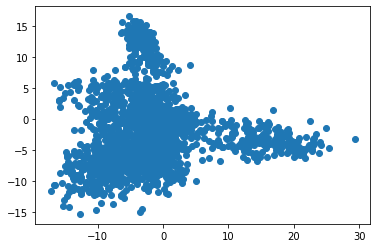

/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/data/anjliu/venv_kaggle_nfl/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:247: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


(715579,)


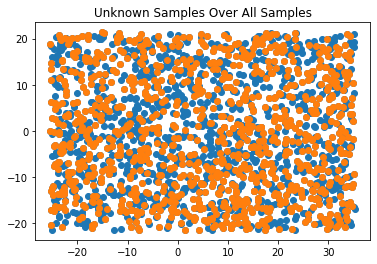

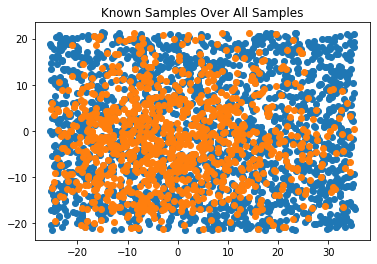

In [22]:
tf.random.set_seed(0)

plt.scatter(e_mnist_train[:2000, 0], e_mnist_train[:2000, 1])
plt.show()

z_q_sample, z_q_weight = sample_enrichment_IF(0, e_mnist_train, 60000*15)
z_q_weight = 1 - z_q_weight * 1.0

tau = np.sort(z_q_weight)[int(z_q_weight.shape[0] *.1)]

# Unknown Samples
cond1 = (z_q_weight > tau)
cond1 = np.squeeze(cond1)
# Known Samples
cond2 = (z_q_weight <= tau)
cond2 = np.squeeze(cond2)
# Wipe Known Samples
z_q_weight[cond2] = 0
# Balance the weights
z_q_weight = z_q_weight * (z_q_weight.shape[0] / z_q_weight.sum())

plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond1, 0][:1000], z_q_sample[cond1, 1][:1000])
plt.title('Unknown Samples Over All Samples')
plt.show()
plt.scatter(z_q_sample[:2000, 0], z_q_sample[:2000, 1])
plt.scatter(z_q_sample[cond2, 0][:1000], z_q_sample[cond2, 1][:1000])
plt.title('Known Samples Over All Samples')
plt.show()

In [31]:
z_q_sample_idx = np.random.permutation(z_q_sample.shape[0])[:60000*m]
    
z_q_sample_sub = z_q_sample[z_q_sample_idx,:]
z_q_weight_sub = z_q_weight[z_q_sample_idx]

In [32]:
z_q_sample_idx

array([719326, 570750, 563768, ..., 414756, 398337, 667647])

In [29]:
z_q_weight_sub

1.2161668448811531

# Openset Learning

In [12]:
from aosr_utility import aosr_risk

In [33]:
def mnist_exp(r_seed, beta=0.1, m=3):
    # ================================================================== #
    #                                 FYI                                #
    # Design the Open-set Learning Model is a complicated task           #
    # At this stage, we only evaluate the openset learning loss          #
    # How to design proper openset model is consider as our future work  #
    # Since we use the closed-set output as our encoder, the Open-set    # 
    # the Open-set neural network is relatively simple                   #
    # ================================================================== #
    tf.random.set_seed(r_seed)
    detetor = tf.keras.models.Sequential([
        tf.keras.layers.Dense(11),
        tf.keras.layers.Activation(activation='softmax')
    ])
    
    z_q_sample_idx = np.random.permutation(z_q_sample.shape[0])[:60000*m]
    
    z_q_sample_sub = z_q_sample[z_q_sample_idx,:]
    z_q_weight_sub = z_q_weight[z_q_sample_idx]
    print(z_q_sample_sub.shape)
    print(z_q_weight_sub.shape)
    detetor.compile(optimizer='adam',
                    loss='sparse_categorical_crossentropy',
                    metrics=['accuracy'])
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=2)

    detetor.compile(optimizer='adam',
                    loss=aosr_risk(detetor, z_q_sample_sub, z_q_weight_sub, e_mnist_train, beta, 10),
                    metrics=['accuracy'])

    K.set_value(detetor.optimizer.learning_rate, 0.001)
    detetor.fit(e_mnist_train, y_mnist_train * 1.0, epochs=25)


    mniTe_pred = detetor.predict(e_mnist_test)
    mniTe_pred = mniTe_pred.argmax(axis=1)
    print('x_mnist_test acc', accuracy_score(y_mnist_test, mniTe_pred))

    mniTr_pred = detetor.predict(e_mnist_train)
    mniTr_pred = mniTr_pred.argmax(axis=1)
    print('x_mnist_train detection rate', (mniTr_pred == 10).sum() / 60000)
    print('x_mnist_test detection rate', (mniTe_pred == 10).sum() / 10000)

    omnig_pred = detetor.predict(e_omniglot_test)
    omnig_pred = omnig_pred.argmax(axis=1)
    print('x_omniglot_test detection rate', (omnig_pred == 10).sum() / 10000)

    mnisN_pred = detetor.predict(e_mnist_noise_test)
    mnisN_pred = mnisN_pred.argmax(axis=1)
    print('x_mnist_noise_test detection rate', (mnisN_pred == 10).sum() / 10000)

    noise_pred = detetor.predict(e_noise_test)
    noise_pred = noise_pred.argmax(axis=1)
    print('x_noise_test detection rate', (noise_pred == 10).sum() / 10000)

    sample_size = 10000
    true_label = np.zeros(sample_size*2) + 10
    true_label[:sample_size] = y_mnist_test

    omnig_f1 = f1_score(true_label, np.concatenate([mniTe_pred,omnig_pred]), average='macro')
    mnisN_f1 = f1_score(true_label, np.concatenate([mniTe_pred,mnisN_pred]), average='macro')
    noise_f1 = f1_score(true_label, np.concatenate([mniTe_pred,noise_pred]), average='macro')

    playground_result = pd.DataFrame()
    playground_result['detector'] = ['aosr_risk']
    playground_result['omnig_f1'] = [omnig_f1]
    playground_result['mnisN_f1'] = [mnisN_f1]
    playground_result['noise_f1'] = [noise_f1]
    return playground_result

## Parameter Beta Analysis

In [34]:
result_list =[]
m_list = [3, 5, 10, 15]
for m in m_list:
    for itr in range(5):
        result_df = mnist_exp(itr, 0.1, m)
        result_df['m'] = m
        result_list.append(result_df)
result = pd.concat(result_list, axis=0)
print(result.mean())
print(result.std())
result

(180000, 10)
(180000,)
Epoch 1/2
1875/1875 [==============================] - 2s 825us/step - loss: 1.8241 - accuracy: 0.7058
Epoch 2/2
1875/1875 [==============================] - 2s 825us/step - loss: 0.0348 - accuracy: 0.9907
Epoch 1/25
1875/1875 [==============================] - 4s 2ms/step - loss: 249896970.5267 - accuracy: 0.9921
Epoch 2/25
1875/1875 [==============================] - 3s 2ms/step - loss: 41946.3824 - accuracy: 0.9925
Epoch 3/25
1875/1875 [==============================] - 3s 2ms/step - loss: 40952.8642 - accuracy: 0.9913
Epoch 4/25
1875/1875 [==============================] - 3s 2ms/step - loss: 38551.0261 - accuracy: 0.9915
Epoch 5/25
1875/1875 [==============================] - 3s 2ms/step - loss: 33407.1513 - accuracy: 0.9913
Epoch 6/25
1875/1875 [==============================] - 3s 2ms/step - loss: 20479.6249 - accuracy: 0.9902
Epoch 7/25
1875/1875 [==============================] - 3s 2ms/step - loss: 5954.1925 - accuracy: 0.9873
Epoch 8/25
1875/1875 [====

1875/1875 [==============================] - 3s 2ms/step - loss: 1.5030 - accuracy: 0.9311
Epoch 19/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.3114 - accuracy: 0.9284
Epoch 20/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1920 - accuracy: 0.9152
Epoch 21/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1356 - accuracy: 0.9132
Epoch 22/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1278 - accuracy: 0.9112
Epoch 23/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1365 - accuracy: 0.9098
Epoch 24/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1268 - accuracy: 0.9123
Epoch 25/25
1875/1875 [==============================] - 3s 2ms/step - loss: 1.1272 - accuracy: 0.9117
x_mnist_test acc 0.9125
x_mnist_train detection rate 0.08135
x_mnist_test detection rate 0.0822
x_omniglot_test detection rate 0.5916
x_mnist_noise_test detection rate 0.9997
x_noise_test 

Epoch 9/25
1875/1875 [==============================] - 4s 2ms/step - loss: 324.4348 - accuracy: 0.9794
Epoch 10/25
1875/1875 [==============================] - 4s 2ms/step - loss: 117.9409 - accuracy: 0.9738
Epoch 11/25
1875/1875 [==============================] - 4s 2ms/step - loss: 45.7301 - accuracy: 0.9689
Epoch 12/25
1875/1875 [==============================] - 4s 2ms/step - loss: 18.6030 - accuracy: 0.9665
Epoch 13/25
1875/1875 [==============================] - 4s 2ms/step - loss: 8.9114 - accuracy: 0.9660
Epoch 14/25
1875/1875 [==============================] - 4s 2ms/step - loss: 5.1026 - accuracy: 0.9581
Epoch 15/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3.4775 - accuracy: 0.9498
Epoch 16/25
1875/1875 [==============================] - 4s 2ms/step - loss: 2.4697 - accuracy: 0.9449
Epoch 17/25
1875/1875 [==============================] - 4s 2ms/step - loss: 1.8066 - accuracy: 0.9357
Epoch 18/25
1875/1875 [==============================] - 4s 2ms/step

1875/1875 [==============================] - 1s 771us/step - loss: 0.0334 - accuracy: 0.9925
Epoch 1/25
1875/1875 [==============================] - 5s 2ms/step - loss: 183469173.6652 - accuracy: 0.9937
Epoch 2/25
1875/1875 [==============================] - 4s 2ms/step - loss: 37179.1098 - accuracy: 0.9939
Epoch 3/25
1875/1875 [==============================] - 4s 2ms/step - loss: 18906.0154 - accuracy: 0.9939
Epoch 4/25
1875/1875 [==============================] - 4s 2ms/step - loss: 18418.5406 - accuracy: 0.9933
Epoch 5/25
1875/1875 [==============================] - 4s 2ms/step - loss: 17269.6186 - accuracy: 0.9938
Epoch 6/25
1875/1875 [==============================] - 4s 2ms/step - loss: 14576.6189 - accuracy: 0.9931
Epoch 7/25
1875/1875 [==============================] - 4s 2ms/step - loss: 3231.6870 - accuracy: 0.9924
Epoch 8/25
1875/1875 [==============================] - 4s 2ms/step - loss: 806.7584 - accuracy: 0.9915
Epoch 9/25
1875/1875 [==============================] - 4s

1875/1875 [==============================] - 5s 3ms/step - loss: 1.3072 - accuracy: 0.9232
Epoch 21/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1883 - accuracy: 0.9150
Epoch 22/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1427 - accuracy: 0.9116
Epoch 23/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1286 - accuracy: 0.9093
Epoch 24/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1346 - accuracy: 0.9103
Epoch 25/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.1327 - accuracy: 0.9095
x_mnist_test acc 0.9004
x_mnist_train detection rate 0.09306666666666667
x_mnist_test detection rate 0.0944
x_omniglot_test detection rate 0.5986
x_mnist_noise_test detection rate 0.9998
x_noise_test detection rate 1.0
(600000, 10)
(600000,)
Epoch 1/2
1875/1875 [==============================] - 2s 778us/step - loss: 2.9630 - accuracy: 0.6454
Epoch 2/2
1875/1875 [============================

1875/1875 [==============================] - 5s 3ms/step - loss: 116.0358 - accuracy: 0.9891
Epoch 11/25
1875/1875 [==============================] - 5s 3ms/step - loss: 54.0366 - accuracy: 0.9841
Epoch 12/25
1875/1875 [==============================] - 5s 3ms/step - loss: 25.8039 - accuracy: 0.9809
Epoch 13/25
1875/1875 [==============================] - 5s 3ms/step - loss: 14.7030 - accuracy: 0.9750
Epoch 14/25
1875/1875 [==============================] - 5s 3ms/step - loss: 8.2600 - accuracy: 0.9675
Epoch 15/25
1875/1875 [==============================] - 5s 3ms/step - loss: 4.3291 - accuracy: 0.9584
Epoch 16/25
1875/1875 [==============================] - 5s 3ms/step - loss: 2.4852 - accuracy: 0.9461
Epoch 17/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.7442 - accuracy: 0.9330
Epoch 18/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.5571 - accuracy: 0.9333
Epoch 19/25
1875/1875 [==============================] - 5s 3ms/step - loss: 1.4

1875/1875 [==============================] - 9s 4ms/step - loss: 339091897.5224 - accuracy: 0.9869
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 10047.7198 - accuracy: 0.9831
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 9989.1331 - accuracy: 0.9843
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 9840.2107 - accuracy: 0.9829
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 9410.5256 - accuracy: 0.9832
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 5516.3706 - accuracy: 0.9821
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 2331.0529 - accuracy: 0.9797
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1044.6608 - accuracy: 0.9782
Epoch 9/25
1875/1875 [==============================] - 7s 4ms/step - loss: 314.2126 - accuracy: 0.9737
Epoch 10/25
1875/1875 [==============================] - 7s 4

1875/1875 [==============================] - 7s 4ms/step - loss: 1.1843 - accuracy: 0.9126
Epoch 22/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1314 - accuracy: 0.9117
Epoch 23/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1284 - accuracy: 0.9115
Epoch 24/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1267 - accuracy: 0.9116
Epoch 25/25
1875/1875 [==============================] - 7s 4ms/step - loss: 1.1314 - accuracy: 0.9095
x_mnist_test acc 0.9064
x_mnist_train detection rate 0.08673333333333333
x_mnist_test detection rate 0.0885
x_omniglot_test detection rate 0.6041
x_mnist_noise_test detection rate 0.9998
x_noise_test detection rate 1.0
(900000, 10)
(900000,)
Epoch 1/2
1875/1875 [==============================] - 2s 759us/step - loss: 2.9875 - accuracy: 0.6167
Epoch 2/2
1875/1875 [==============================] - 1s 754us/step - loss: 0.0398 - accuracy: 0.9903
Epoch 1/25
1875/1875 [===========================

,detector,omnig_f1,mnisN_f1,noise_f1,m
0,aosr_risk,0.779054,0.942074,0.942226,3
0,aosr_risk,0.784479,0.947562,0.947663,3
0,aosr_risk,0.783682,0.949433,0.949585,3
0,aosr_risk,0.784385,0.946992,0.947093,3
0,aosr_risk,0.778474,0.943612,0.943865,3
0,aosr_risk,0.779897,0.941897,0.942049,5
0,aosr_risk,0.783965,0.947871,0.947972,5
0,aosr_risk,0.782600,0.948510,0.948662,5
0,aosr_risk,0.782916,0.945819,0.945920,5
0,aosr_risk,0.780346,0.943841,0.944094,5


In [35]:
result.to_csv('mnist_exp_result_m.csv')